# Adjoint Method for PDE-Constrained Optimization in the Black–Scholes Model

## Problem Setup: 1D Black–Scholes PDE (Constant Volatility)

**Goal**: Recover the unknown *constant volatility* $\sigma$ from observed European call option prices.

We work with the Black–Scholes PDE for a call option price $V(S, t)$:

$$
\frac{\partial V}{\partial t}
+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
+ r S \frac{\partial V}{\partial S}
- r V = 0,
$$

with

- maturity $T$,
- strike $K$,
- risk-free rate $r$,
- underlying price $S \in (0, S_{\max})$.

Terminal condition (at maturity $t = T$):

$$
V(S, T) = \max(S - K, 0).
$$

Boundary conditions (vanilla call):

- $V(0, t) = 0$,
- $V(S_{\max}, t) \approx S_{\max} - K e^{-r(T-t)}$.

---

To obtain a **forward-in-time parabolic problem**, we introduce time-to-maturity

$$
\tau = T - t, \quad \tau \in [0, T].
$$

Then

$$
\frac{\partial V}{\partial \tau}
= \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
+ r S \frac{\partial V}{\partial S}
- r V,
$$

with **initial condition** at $\tau = 0$:

$$
V(S, 0) = \max(S - K, 0),
$$

and boundary conditions in $\tau$:

- $V(0, \tau) = 0$,
- $V(S_{\max}, \tau) \approx S_{\max} - K e^{-r \tau}$.

We discretize $S \in [0, S_{\max}]$ and $\tau \in [0, T]$ and solve forward in $\tau$.

---

## Optimization Problem

We generate synthetic "observed" call prices $V_{\text{obs}}(S_i)$ at $\tau = T$ using a known true volatility $\sigma^*$.  
We then solve the inverse problem:

$$
\min_\sigma J(\sigma)
= \frac{1}{2} \sum_{i} \big( V_\sigma(S_i, \tau = T) - V_{\text{obs}}(S_i) \big)^2.
$$

**Method**:

- Use an explicit finite-difference scheme for the forward PDE.
- Use the **discrete adjoint method** to compute $dJ/d\sigma$.
- Use gradient descent to recover $\sigma^*$.

We also **save the synthetic data** to `bs_pde_adjoint_data.npz` to ensure reproducibility.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters and Grid Setup ---

# Financial parameters
K = 100.0     # strike
T = 1.0       # maturity (years)
r = 0.02      # risk-free rate

# Spatial domain in S: [0, S_max]
S_max = 400.0

# Discretization
nx = 200          # number of spatial points
nt = 5000         # number of time steps in tau

dS = S_max / (nx - 1)
dt = T / (nt - 1)

S = np.linspace(0.0, S_max, nx)    # S-grid
tau = np.linspace(0.0, T, nt)      # tau-grid (time-to-maturity)

S_mesh, tau_mesh = np.meshgrid(S, tau)

# A rough CFL-like number for the diffusion part
sigma_ref = 0.3
cfl_number = 0.5 * sigma_ref**2 * (S_max**2) * dt / (dS**2)
print(f"Approximate diffusion CFL (sigma={sigma_ref}): {cfl_number:.4f} (should be ~O(1) or smaller for stability)")

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


Approximate diffusion CFL (sigma=0.3): 0.3565 (should be ~O(1) or smaller for stability)


In [4]:
# --- 2. Operator coefficients for the Black–Scholes PDE in tau ---

def bs_operator_coeffs(sigma):
    """
    Compute coefficients alpha, beta, gamma for the spatial operator A(V):

        A_i(V) = alpha[i] * V[i-1] + beta[i] * V[i] + gamma[i] * V[i+1]

    so that the explicit scheme is:

        V_{n+1,i} = V_{n,i} + dt * A_i(V_n).

    Central differences:

        V_S  ~ (V[i+1] - V[i-1]) / (2 dS)
        V_SS ~ (V[i+1] - 2 V[i] + V[i-1]) / dS^2

    and

        A_i(V) = 0.5 * sigma^2 * S_i^2 * V_SS
                 + r * S_i * V_S
                 - r * V_i.
    """
    alpha = np.zeros(nx)
    beta = np.zeros(nx)
    gamma = np.zeros(nx)

    for i in range(1, nx - 1):
        Si = S[i]
        diff_coeff = 0.5 * sigma**2 * Si**2
        adv_coeff = r * Si

        # Second derivative contribution
        c_im1_d2 = diff_coeff / (dS**2)
        c_i_d2   = -2.0 * diff_coeff / (dS**2)
        c_ip1_d2 = diff_coeff / (dS**2)

        # First derivative contribution
        c_im1_d1 = -adv_coeff / (2.0 * dS)
        c_i_d1   = 0.0
        c_ip1_d1 = adv_coeff / (2.0 * dS)

        # -r V term
        c_i_zero = -r

        c_im1 = c_im1_d2 + c_im1_d1
        c_i   = c_i_d2   + c_i_d1   + c_i_zero
        c_ip1 = c_ip1_d2 + c_ip1_d1

        alpha[i] = c_im1
        beta[i]  = c_i
        gamma[i] = c_ip1

    return alpha, beta, gamma


def bs_operator_coeffs_sigma_deriv(sigma):
    """
    Derivatives of alpha, beta, gamma w.r.t. sigma.

    diff_coeff = 0.5 * sigma^2 * S_i^2
    d(diff_coeff)/d sigma = sigma * S_i^2
    """
    dalpha = np.zeros(nx)
    dbeta  = np.zeros(nx)
    dgamma = np.zeros(nx)

    for i in range(1, nx - 1):
        Si2 = S[i]**2
        d_diff_dsigma = sigma * Si2

        d_c_im1_d2 = d_diff_dsigma / (dS**2)
        d_c_i_d2   = -2.0 * d_diff_dsigma / (dS**2)
        d_c_ip1_d2 = d_diff_dsigma / (dS**2)

        # First-derivative and -r V terms do not depend on sigma
        d_c_im1_d1 = 0.0
        d_c_i_d1   = 0.0
        d_c_ip1_d1 = 0.0
        d_c_i_zero = 0.0

        d_c_im1 = d_c_im1_d2 + d_c_im1_d1
        d_c_i   = d_c_i_d2   + d_c_i_d1   + d_c_i_zero
        d_c_ip1 = d_c_ip1_d2 + d_c_ip1_d1

        dalpha[i] = d_c_im1
        dbeta[i]  = d_c_i
        dgamma[i] = d_c_ip1

    return dalpha, dbeta, dgamma


## Solvers (Forward & Adjoint)

We implement two solvers using the Finite Difference Method:

1.  **Forward Solver**: Solves $u_t - u_{xx} = f$ forward in time to get $u$.
2.  **Adjoint Solver**: Solves $-p_t - p_{xx} = (u - u_{obs})$ backward in time to get the adjoint variable $p$.

The gradient of the cost function with respect to $f$ is simply the adjoint variable $p$.

In [5]:
# --- 3. Forward Solver: Black–Scholes PDE in tau ---

def solve_forward(sigma):
    """
    Solve the BS PDE in tau:

        V_tau = A(V; sigma),

    using an explicit Euler scheme in tau and central differences in S.

    Initial condition (tau = 0):
        V(S, 0) = max(S - K, 0)

    Boundary conditions:
        V(0, tau)      = 0
        V(S_max, tau)  = S_max - K * exp(-r * tau)
    """
    V = np.zeros((nt, nx))

    # Initial condition
    V[0, :] = np.maximum(S - K, 0.0)

    alpha, beta, gamma = bs_operator_coeffs(sigma)

    # Time marching
    for n in range(0, nt - 1):
        tau_n = tau[n]

        # Boundary at current time level
        V[n, 0]  = 0.0
        V[n, -1] = S_max - K * np.exp(-r * tau_n)

        # Interior update
        for i in range(1, nx - 1):
            A_i = (
                alpha[i] * V[n, i - 1]
                + beta[i]  * V[n, i]
                + gamma[i] * V[n, i + 1]
            )
            V[n + 1, i] = V[n, i] + dt * A_i

        tau_np1 = tau[n + 1]
        V[n + 1, 0]  = 0.0
        V[n + 1, -1] = S_max - K * np.exp(-r * tau_np1)

    return V


In [6]:
# --- 4. Synthetic "market" data generation and saving ---

sigma_true = 0.25

V_true = solve_forward(sigma_true)
V_true_final = V_true[-1, :]  # prices at tau = T (original t = 0)

# Choose a subset of grid points as observed strikes
num_data_points = 30
data_indices = np.linspace(5, nx - 6, num_data_points, dtype=int)
S_data = S[data_indices]

# Observed prices (optionally add noise)
noise_std = 0.0
V_obs = V_true_final[data_indices] + noise_std * np.random.randn(num_data_points)

# Save to disk
data_filename = "bs_pde_adjoint_data.npz"
np.savez(
    data_filename,
    S=S,
    tau=tau,
    V_true_final=V_true_final,
    S_data=S_data,
    V_obs=V_obs,
    sigma_true=sigma_true,
    data_indices=data_indices,
    K=K,
    T=T,
    r=r,
    S_max=S_max,
)
print(f"Synthetic data saved to: {data_filename}")
print("First 5 S_data:", S_data[:5])
print("First 5 V_obs:", V_obs[:5])
print("True sigma:", sigma_true)


Synthetic data saved to: bs_pde_adjoint_data.npz
First 5 S_data: [10.05025126 22.11055276 36.18090452 48.24120603 62.31155779]
First 5 V_obs: [1.65948430e-15 1.09301246e-08 1.37461886e-04 1.19764761e-02
 2.70220435e-01]
True sigma: 0.25


## 5. Discrete Adjoint Method for the Volatility Parameter

The forward scheme for interior nodes $i$ can be written as

$$
V_{n+1,i} = V_{n,i} + \Delta t \, A_i(V_n; \sigma),
$$

where

$$
A_i(V_n; \sigma) =
\alpha_i(\sigma) V_{n,i-1}
+ \beta_i(\sigma) V_{n,i}
+ \gamma_i(\sigma) V_{n,i+1}.
$$

The discrete objective is

$$
J(\sigma) = \frac{1}{2} \sum_{k} 
\big( V_{N_\tau-1, i_k} - V_{\text{obs},k} \big)^2,
$$

where $N_\tau = \text{nt}$ and $i_k$ are the indices with data.

---

### Adjoint Variables

Introduce adjoint variables $\lambda_{n,i}$.  
At final time $n = N_\tau-1$:

$$
\lambda_{N_\tau-1, i} = 
\begin{cases}
V_{N_\tau-1, i} - V_{\text{obs},k}, & i = i_k, \\
0, & \text{otherwise}.
\end{cases}
$$

For $n = N_\tau-2, \dots, 0$ the adjoint recursion from the discrete Lagrangian is

$$
\lambda_{n,j} = 
\lambda_{n+1,j} \big(1 + \Delta t\,\beta_j \big)
+ \lambda_{n+1,j-1} \Delta t\,\gamma_{j-1}
+ \lambda_{n+1,j+1} \Delta t\,\alpha_{j+1},
$$

for $j = 1,\dots,nx-2$, with boundary adjoints $\lambda_{n,0} = \lambda_{n,nx-1} = 0$.

---

### Gradient with respect to $\sigma$

The contribution at time step $n$ is

$$
\frac{\partial V_{n+1,i}}{\partial \sigma}
= \Delta t \Big(
\alpha_i'(\sigma) V_{n,i-1}
+ \beta_i'(\sigma) V_{n,i}
+ \gamma_i'(\sigma) V_{n,i+1}
\Big),
$$

so the total gradient is

$$
\frac{dJ}{d\sigma} =
\sum_{n=0}^{N_\tau-2} \sum_{i=1}^{nx-2}
\lambda_{n+1,i}
\frac{\partial V_{n+1,i}}{\partial \sigma}.
$$

We now implement this discrete adjoint and gradient computation.


In [7]:
# --- 6. Discrete adjoint solver and gradient w.r.t sigma ---

# Reload data to emphasize reproducibility
loaded = np.load("bs_pde_adjoint_data.npz")
S_data = loaded["S_data"]
V_obs = loaded["V_obs"]
data_indices = loaded["data_indices"]
sigma_true_loaded = float(loaded["sigma_true"])
print("Loaded data file:", data_filename)
print("Loaded true sigma:", sigma_true_loaded)

def compute_objective_and_gradient(sigma):
    """
    Given volatility sigma, compute:
    - forward solution V
    - objective J(sigma)
    - adjoint variables lambda
    - gradient dJ/dsigma via discrete adjoint
    """
    V = solve_forward(sigma)
    V_final = V[-1, :]

    # Objective
    residuals = V_final[data_indices] - V_obs
    J = 0.5 * np.sum(residuals**2)

    # Initialize adjoint
    lam = np.zeros_like(V)
    lam_final = np.zeros(nx)
    for k, idx in enumerate(data_indices):
        lam_final[idx] += residuals[k]
    lam_final[0] = 0.0
    lam_final[-1] = 0.0
    lam[-1, :] = lam_final

    alpha, beta, gamma = bs_operator_coeffs(sigma)
    dalpha, dbeta, dgamma = bs_operator_coeffs_sigma_deriv(sigma)

    grad_sigma = 0.0

    # Backward in time
    for n in range(nt - 2, -1, -1):
        lam_n = np.zeros(nx)

        # Adjoint update
        for j in range(1, nx - 1):
            lam_n[j] = (
                lam[n + 1, j] * (1.0 + dt * beta[j])
                + lam[n + 1, j - 1] * dt * gamma[j - 1]
                + lam[n + 1, j + 1] * dt * alpha[j + 1]
            )

        lam_n[0] = 0.0
        lam_n[-1] = 0.0
        lam[n, :] = lam_n

        # Gradient accumulation
        Vn = V[n, :]
        for i in range(1, nx - 1):
            dV_dsigma = dt * (
                dalpha[i] * Vn[i - 1]
                + dbeta[i]  * Vn[i]
                + dgamma[i] * Vn[i + 1]
            )
            grad_sigma += lam[n + 1, i] * dV_dsigma

    return J, grad_sigma, V, lam


Loaded data file: bs_pde_adjoint_data.npz
Loaded true sigma: 0.25


In [8]:
# --- 7. Gradient check: adjoint vs finite difference ---

sigma_test = 0.20

J_adj, grad_adj, _, _ = compute_objective_and_gradient(sigma_test)

eps = 1e-4
J_plus, _, _, _ = compute_objective_and_gradient(sigma_test + eps)
J_minus, _, _, _ = compute_objective_and_gradient(sigma_test - eps)
grad_fd = (J_plus - J_minus) / (2.0 * eps)

print(f"At sigma = {sigma_test:.4f}")
print(f"  J(sigma)          = {J_adj:.6e}")
print(f"  dJ/dsigma (adj)   = {grad_adj:.6e}")
print(f"  dJ/dsigma (FD)    = {grad_fd:.6e}")
rel_err = (grad_adj - grad_fd) / (grad_fd + 1e-16)
print(f"  Relative error    = {rel_err:.2e}")


At sigma = 0.2000
  J(sigma)          = 5.924854e+00
  dJ/dsigma (adj)   = -2.221076e+02
  dJ/dsigma (FD)    = -2.221075e+02
  Relative error    = 2.77e-07


In [20]:
# --- 8. Optimization Loop: recover sigma_true ---

LEARNING_RATE = 1e-5
EPOCHS = 100

sigma_current = 0.10
sigma_history = []
loss_history = []

print("Starting optimization...")
print(f"Initial sigma: {sigma_current:.4f}, true sigma: {sigma_true_loaded:.4f}")

for epoch in range(EPOCHS + 1):
    J_val, grad_val, V_cur, lam_cur = compute_objective_and_gradient(sigma_current)

    sigma_history.append(sigma_current)
    loss_history.append(J_val)

    # Gradient descent step
    sigma_current = sigma_current - LEARNING_RATE * grad_val
    sigma_current = max(sigma_current, 1e-6)  # keep sigma positive

    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d}: J = {J_val:.6e}, "
              f"sigma = {sigma_current:.66f}, grad = {grad_val:.6e}")

print("\nOptimization finished.")
print("True sigma:", sigma_true_loaded)
print("Recovered sigma (last iterate):", sigma_current)


Starting optimization...
Initial sigma: 0.1000, true sigma: 0.2500
Epoch   0: J = 3.935363e+01, sigma = 0.103774466299231732380192738673940766602754592895507812500000000000, grad = -3.774466e+02
Epoch   5: J = 3.212186e+01, sigma = 0.122813189939814049189692468644352629780769348144531250000000000000, grad = -3.807472e+02
Epoch  10: J = 2.504547e+01, sigma = 0.141524528812540545397169466923514846712350845336914062500000000000, grad = -3.678574e+02
Epoch  15: J = 1.867161e+01, sigma = 0.159174666214735333058527544380922336131334304809570312500000000000, grad = -3.415752e+02
Epoch  20: J = 1.334689e+01, sigma = 0.175217235685156458302458304387982934713363647460937500000000000000, grad = -3.061178e+02
Epoch  25: J = 9.185497e+00, sigma = 0.189329413170932325805040363775333389639854431152343750000000000000, grad = -2.659881e+02
Epoch  30: J = 6.115423e+00, sigma = 0.201398874797756061161280172200349625200033187866210937500000000000, grad = -2.251108e+02
Epoch  35: J = 3.958238e+00, sigma = 

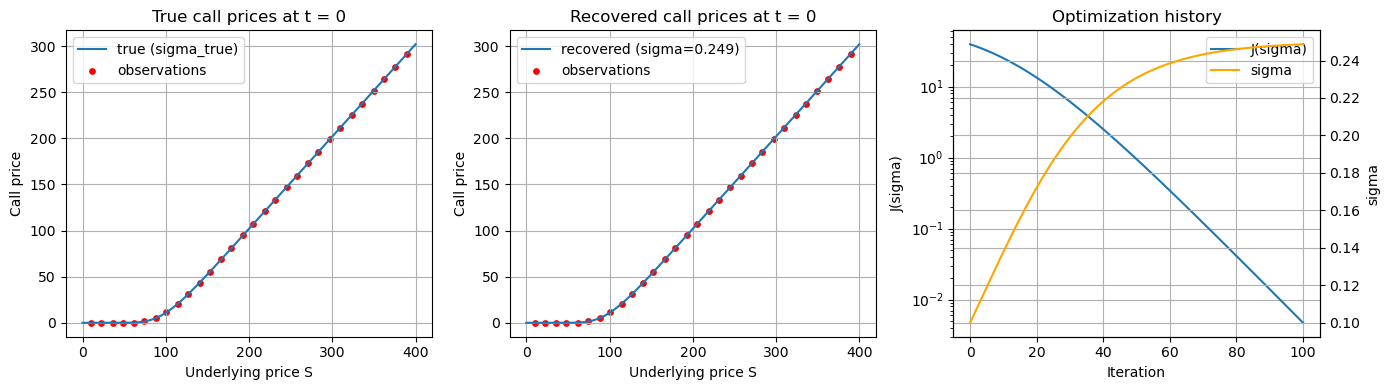

In [21]:
# --- 9. Visualization ---

plt.figure(figsize=(14, 4))

# 1. True prices at t=0
plt.subplot(1, 3, 1)
plt.title("True call prices at t = 0")
plt.plot(S, V_true_final, label="true (sigma_true)")
plt.scatter(S_data, V_obs, color="red", s=15, label="observations")
plt.xlabel("Underlying price S")
plt.ylabel("Call price")
plt.legend()

# 2. Recovered prices at t=0
V_recovered = solve_forward(sigma_current)
V_recovered_final = V_recovered[-1, :]

plt.subplot(1, 3, 2)
plt.title("Recovered call prices at t = 0")
plt.plot(S, V_recovered_final, label=f"recovered (sigma={sigma_current:.3f})")
plt.scatter(S_data, V_obs, color="red", s=15, label="observations")
plt.xlabel("Underlying price S")
plt.ylabel("Call price")
plt.legend()

# 3. J(sigma) and sigma history
plt.subplot(1, 3, 3)
plt.title("Optimization history")
ax1 = plt.gca()
ax1.plot(loss_history, label="J(sigma)")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("J(sigma)")
ax1.set_yscale("log")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(sigma_history, color="orange", label="sigma")
ax2.set_ylabel("sigma")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.tight_layout()
plt.show()


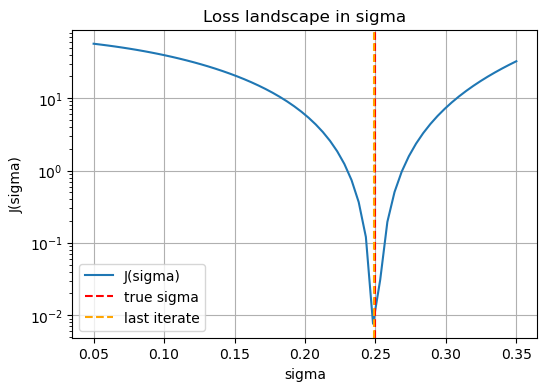

In [22]:
# --- Extra: loss landscape J(sigma) ---

sigmas = np.linspace(0.05, 0.35, 60)
J_values = []

for s in sigmas:
    J_s, _, _, _ = compute_objective_and_gradient(s)
    J_values.append(J_s)

plt.figure(figsize=(6, 4))
plt.plot(sigmas, J_values, label="J(sigma)")
plt.axvline(sigma_true_loaded, color="red", linestyle="--", label="true sigma")
plt.axvline(sigma_current, color="orange", linestyle="--", label="last iterate")
plt.xlabel("sigma")
plt.ylabel("J(sigma)")
plt.yscale("log")
plt.title("Loss landscape in sigma")
plt.legend()
plt.grid(True)
plt.show()


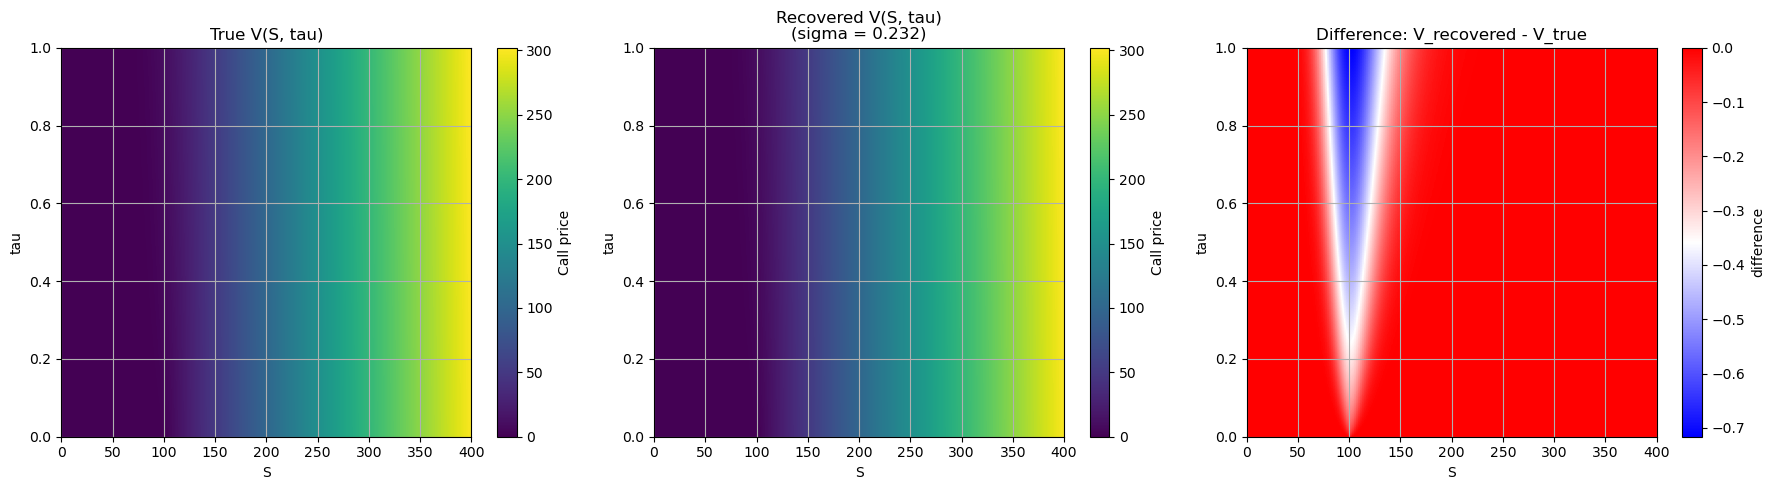

In [12]:
# --- Extra: 2D solution fields V_true(S, tau) and V_recovered(S, tau) ---

# Forward solve with true sigma and recovered sigma
V_true_full = solve_forward(sigma_true_loaded)
V_rec_full = solve_forward(sigma_current)

plt.figure(figsize=(18, 5))

# 1. True solution field
plt.subplot(1, 3, 1)
plt.title("True V(S, tau)")
plt.imshow(
    V_true_full,
    aspect="auto",
    origin="lower",
    extent=[S[0], S[-1], tau[0], tau[-1]],
    cmap="viridis",
)
plt.colorbar(label="Call price")
plt.xlabel("S")
plt.ylabel("tau")

# 2. Recovered solution field
plt.subplot(1, 3, 2)
plt.title(f"Recovered V(S, tau)\n(sigma = {sigma_current:.3f})")
plt.imshow(
    V_rec_full,
    aspect="auto",
    origin="lower",
    extent=[S[0], S[-1], tau[0], tau[-1]],
    cmap="viridis",
)
plt.colorbar(label="Call price")
plt.xlabel("S")
plt.ylabel("tau")

# 3. Difference field
plt.subplot(1, 3, 3)
plt.title("Difference: V_recovered - V_true")
plt.imshow(
    V_rec_full - V_true_full,
    aspect="auto",
    origin="lower",
    extent=[S[0], S[-1], tau[0], tau[-1]],
    cmap="bwr",
)
plt.colorbar(label="difference")
plt.xlabel("S")
plt.ylabel("tau")

plt.tight_layout()
plt.show()


In [14]:
# ================================
# Stage 2: Real Market Calibration
# ================================

import numpy as np
import matplotlib.pyplot as plt

# --- S2-1. Utility: Load market option data ---

def load_market_data_from_csv(csv_path):
    """
    Example CSV format (one row per option):
        K, T_years, mid_price
    where:
        - K: strike
        - T_years: time-to-maturity in years (e.g. 0.25, 0.5, 1.0)
        - mid_price: (bid + ask) / 2, or last price if you want

    This is a placeholder: adapt it to your actual CSV schema.
    """
    data = np.genfromtxt(csv_path, delimiter=",", names=True)
    K_data = data["K"]
    T_data = data["T_years"]
    V_market = data["mid_price"]
    return K_data, T_data, V_market


def load_market_data_dummy():
    """
    Dummy loader: use the Stage 1 synthetic setup as a stand-in
    for real market data. Replace this with load_market_data_from_csv
    once you have a real CSV file.

    Here we simply pretend that:
        - underlying spot S0 ~ some S-grid location,
        - all options have the same maturity T,
        - K_data is a subset of S-grid,
        - V_market is taken from V_true_final (Stage 1) with a bit of noise.
    """
    # Use global S, V_true_final from Stage 1 if available;
    # otherwise, create a small synthetic example.
    global S, V_true_final, sigma_true

    if "S" not in globals() or "V_true_final" not in globals():
        # fallback: make a mini synthetic example
        S_local = np.linspace(10.0, 200.0, 50)
        sigma_true_local = 0.25
        # here you could call a Black–Scholes closed-form instead
        V_local = np.maximum(S_local - 100.0, 0.0)  # crude placeholder
        noise_std = 0.1
        V_market_local = V_local + noise_std * np.random.randn(len(S_local))
        K_data = S_local.copy()
        T_data = np.ones_like(K_data) * 1.0  # 1-year maturity
        V_market = V_market_local
        return K_data, T_data, V_market

    # If Stage 1 already ran, use its V_true_final as synthetic "market"
    num_data_points = 30
    idx = np.linspace(5, len(S) - 6, num_data_points, dtype=int)
    K_data = S[idx].copy()
    T_data = np.ones_like(K_data) * T   # same maturity T as Stage 1
    noise_std = 0.0
    V_market = V_true_final[idx] + noise_std * np.random.randn(num_data_points)
    return K_data, T_data, V_market


# Choose which loader to use:
# If you already have a CSV file (e.g. "spx_options_2025-01-15.csv"),
# uncomment the CSV loader and comment out the dummy one.
# K_data, T_data, V_market = load_market_data_from_csv("your_option_chain.csv")
K_data, T_data, V_market = load_market_data_dummy()

print("Number of market options:", len(K_data))
print("First 5 K_data:", K_data[:5])
print("First 5 T_data:", T_data[:5])
print("First 5 V_market:", V_market[:5])


Number of market options: 30
First 5 K_data: [10.05025126 22.11055276 36.18090452 48.24120603 62.31155779]
First 5 T_data: [1. 1. 1. 1. 1.]
First 5 V_market: [1.65948430e-15 1.09301246e-08 1.37461886e-04 1.19764761e-02
 2.70220435e-01]


In [15]:
# --- S2-2. Map PDE solution to market option prices ---

from scipy.interpolate import interp1d

def model_prices_from_sigma(sigma, K_data, T_data):
    """
    Given a sigma, compute model prices for each option in (K_data, T_data)
    using the PDE solver from Stage 1.

    Simplest version:
        - assume all T_data are equal to the global T
        - use the final-time slice V[-1, :] (tau = T)
        - interpolate in S to get prices at S = K_i
    """
    # 1. Solve PDE on global grid (tau in [0,T], S in [0,S_max])
    V = solve_forward(sigma)        # shape (nt, nx)
    V_final = V[-1, :]             # tau = T slice

    # 2. Interpolation in S
    interp_fun = interp1d(S, V_final, kind="linear", fill_value="extrapolate")

    V_model = interp_fun(K_data)
    return V_model


# Quick test:
sigma_test = 0.2
V_model_test = model_prices_from_sigma(sigma_test, K_data, T_data)

print("Test model prices (first 5):", V_model_test[:5])


Test model prices (first 5): [2.68248766e-20 4.75493621e-12 1.42703931e-06 7.79360761e-04
 6.44575009e-02]


In [16]:
# --- S2-3. Objective J(sigma) and finite-difference gradient ---

def objective_J(sigma, K_data, T_data, V_market, reg_lambda=0.0):
    """
    Least-squares misfit between model prices and market prices:

        J(sigma) = 0.5 * sum_i (V_model_i - V_market_i)^2
                   + 0.5 * reg_lambda * sigma^2    (optional L2 regularization)

    """
    V_model = model_prices_from_sigma(sigma, K_data, T_data)
    residuals = V_model - V_market
    data_term = 0.5 * np.sum(residuals**2)
    reg_term = 0.5 * reg_lambda * sigma**2
    return data_term + reg_term


def objective_and_grad_fd(sigma, K_data, T_data, V_market, reg_lambda=0.0, eps=1e-4):
    """
    Return (J, dJ/dsigma) using a simple symmetric finite difference for the gradient.
    """
    J0 = objective_J(sigma, K_data, T_data, V_market, reg_lambda=reg_lambda)
    J_plus = objective_J(sigma + eps, K_data, T_data, V_market, reg_lambda=reg_lambda)
    J_minus = objective_J(sigma - eps, K_data, T_data, V_market, reg_lambda=reg_lambda)
    dJ = (J_plus - J_minus) / (2.0 * eps)
    return J0, dJ


In [17]:
# --- S2-4. Gradient Descent on real-data objective ---

LEARNING_RATE_STAGE2 = 1e-4
EPOCHS_STAGE2 = 50
REG_LAMBDA = 0.0    # you can try small positive values, e.g. 1e-4

sigma_init_stage2 = 0.2  # initial guess for market calibration

sigma_hist_s2 = []
loss_hist_s2 = []

sigma_cur = sigma_init_stage2

print("Stage 2: Real-data-like calibration")
print(f"Initial sigma: {sigma_cur:.4f}")

for epoch in range(EPOCHS_STAGE2 + 1):
    J_val, dJ_val = objective_and_grad_fd(
        sigma_cur, K_data, T_data, V_market, reg_lambda=REG_LAMBDA
    )

    sigma_hist_s2.append(sigma_cur)
    loss_hist_s2.append(J_val)

    # Gradient descent step
    sigma_cur = sigma_cur - LEARNING_RATE_STAGE2 * dJ_val
    sigma_cur = max(sigma_cur, 1e-6)  # keep sigma positive

    if epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | J = {J_val:.6e} | sigma = {sigma_cur:.6f} | grad = {dJ_val:.6e}")

print("\nStage 2 finished.")
print("Calibrated sigma (last):", sigma_cur)


Stage 2: Real-data-like calibration
Initial sigma: 0.2000
Epoch   0 | J = 5.924854e+00 | sigma = 0.222211 | grad = -2.221075e+02
Epoch   5 | J = 6.814281e-03 | sigma = 0.249247 | grad = -8.491066e+00
Epoch  10 | J = 3.468619e-06 | sigma = 0.249983 | grad = -1.921726e-01
Epoch  15 | J = 1.767261e-09 | sigma = 0.250000 | grad = -4.281264e-03
Epoch  20 | J = 2.210450e-12 | sigma = 0.250000 | grad = -9.534514e-05
Epoch  25 | J = 3.406498e-13 | sigma = 0.250000 | grad = -2.123350e-06
Epoch  30 | J = 3.175772e-13 | sigma = 0.250000 | grad = -4.728753e-08
Epoch  35 | J = 3.170725e-13 | sigma = 0.250000 | grad = -1.051299e-09
Epoch  40 | J = 3.170613e-13 | sigma = 0.250000 | grad = -2.412734e-11
Epoch  45 | J = 3.170611e-13 | sigma = 0.250000 | grad = -2.882623e-13
Epoch  50 | J = 3.170611e-13 | sigma = 0.250000 | grad = -2.661039e-13

Stage 2 finished.
Calibrated sigma (last): 0.24999998909005314


/var/folders/47/981_vt853kj8481n5s4q35b00000gn/T/ipykernel_81731/1195849858.py:13: RuntimeWarning: overflow encountered in square
  data_term = 0.5 * np.sum(residuals**2)
/var/folders/47/981_vt853kj8481n5s4q35b00000gn/T/ipykernel_81731/3448751143.py:36: RuntimeWarning: overflow encountered in scalar add
  alpha[i] * V[n, i - 1]
/var/folders/47/981_vt853kj8481n5s4q35b00000gn/T/ipykernel_81731/3448751143.py:40: RuntimeWarning: invalid value encountered in scalar add
  V[n + 1, i] = V[n, i] + dt * A_i
/var/folders/47/981_vt853kj8481n5s4q35b00000gn/T/ipykernel_81731/3448751143.py:37: RuntimeWarning: overflow encountered in scalar multiply
  + beta[i]  * V[n, i]


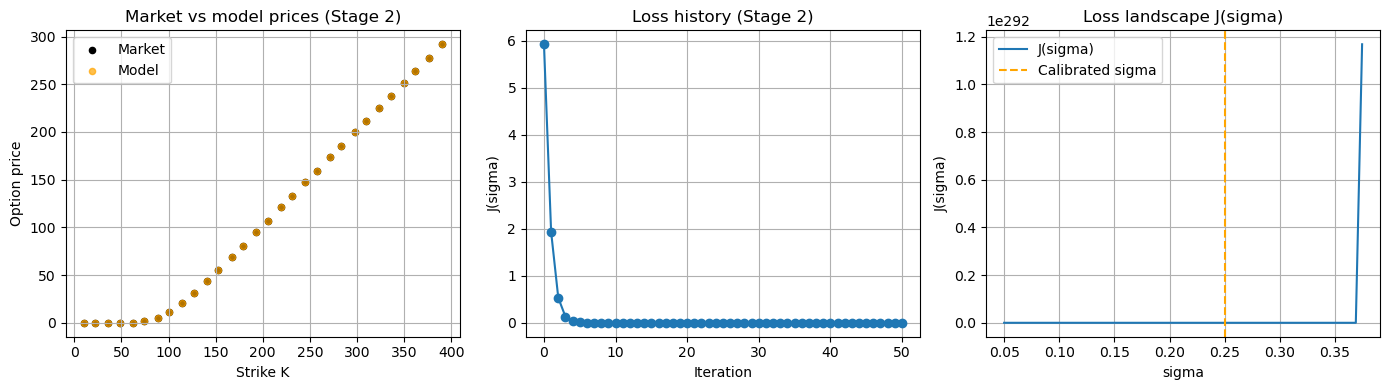

In [23]:
# --- S2-5 (safe version). Visualization for Stage 2 without log scale ---

plt.figure(figsize=(14, 4))

# 1) Market vs model prices for calibrated sigma
plt.subplot(1, 3, 1)
plt.title("Market vs model prices (Stage 2)")
plt.scatter(K_data, V_market, label="Market", color="black", s=20)
V_model_calibrated = model_prices_from_sigma(sigma_cur, K_data, T_data)
plt.scatter(K_data, V_model_calibrated, label="Model", color="orange", s=20, alpha=0.7)
plt.xlabel("Strike K")
plt.ylabel("Option price")
plt.legend()
plt.grid(True)

# 2) Loss history (linear scale to avoid log issues)
plt.subplot(1, 3, 2)
plt.title("Loss history (Stage 2)")

loss_arr = np.array(loss_hist_s2)
iters = np.arange(len(loss_arr))

plt.plot(iters, loss_arr, marker="o")
plt.xlabel("Iteration")
plt.ylabel("J(sigma)")
# 不用 log 轴，避免数值太小 / 0 的问题
# plt.yscale("log")
plt.grid(True)

# 3) Loss landscape J(sigma) (同样用线性坐标)
plt.subplot(1, 3, 3)
plt.title("Loss landscape J(sigma)")

sigmas_scan = np.linspace(0.05, 0.5, 80)
J_scan = np.array([
    objective_J(s, K_data, T_data, V_market, reg_lambda=REG_LAMBDA)
    for s in sigmas_scan
])

plt.plot(sigmas_scan, J_scan, label="J(sigma)")
plt.axvline(sigma_cur, color="orange", linestyle="--", label="Calibrated sigma")
plt.xlabel("sigma")
plt.ylabel("J(sigma)")
# 同样不用 log 轴
# plt.yscale("log")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
